# Graph Neural Networks

Comme leur nom l'indique, les Graph Neural Networks sont des réseaux de
neurones qui traitent les graphes. Ce traitement pose trois
problématiques :

-   leur topologie est variable, et il est difficile de concevoir des
    réseaux qui soient à la fois suffisamment expressifs et capables de
    gérer cette variation.

-   ils peuvent être de taille conséquente : un graphe représentant les
    connexions entre les utilisateurs d'un réseau social peut avoir
    plusieurs millions de sommets.

-   il se peut qu'il n'y ait à disposition pour le problème à traiter
    qu'un seul graphe, de sorte que le protocole habituel d'entraînement
    avec de nombreux exemples de données et de test avec de nouvelles
    données n'est pas toujours possible.

## Représentation d'un graphe

### Définition matricielle d'un graphe

Soit $G=(V,E)$ un graphe à $N=|V|$ sommets et $M=|E|$ arcs (ou arêtes).
Chaque sommet et chaque arc (ou arête) peut porter une information
vectorielle (graphe pondéré). On choisit alors de représenter $G$ par
trois matrices $\mathbf A,\mathbf X$ et $\mathbf E$ représentant
respectivement la struture de $G$, les sommets et arcs (ou arêtes):

1.  $\mathbf A$ est la matrice d'adjacence (pour les arêtes) ou
    d'incidence (pour les arcs).

2.  $\mathbf X$ est une matrice de taille $d\times N$, la $i$-eme
    colonne de $\mathbf X$ donnant les $d$ informations portées par le
    sommet $i\in[\![1,N]\!]$.

3.  $\mathbf E$ est une matrice de taille $d_e\times M$, la $i$-eme
    colonne de $\mathbf E$ donnant les $d_e$ informations portées par
    l'arc (ou l'arête) $i\in[\![1,N]\!]$.

Dans un premier temps, on considérera uniquement le cas où $\mathbf X$
existe (seuls les sommets sont pondérés). On reviendra sur le cas de
$\mathbf E$ plus tard.

### Propriétés

La matrice d'adjacence peut être utilisée pour trouver les voisins d'un
sommet. Supposons que le $i$-eme sommet soit encodé sous la forme d'un
vecteur colonne $\mathbf X_{\bullet,i}$ avec une seule entrée non nulle
à la position $i$, fixée à un. En prémultipliant $\mathbf X_{\bullet,i}$
par la matrice $\mathbf A$, on calcule un vecteur avec des uns aux
positions des voisins. En répétant cette procédure $n$ fois, on accède
aux voisins du sommet $i$ accessibles en $n$ étapes. Ainsi, le
coefficient (l,c) de $\mathbf A^n$ contient le nombre de chaînes uniques
de longueur $n$ du sommet $l$ au sommet $c$. A noter que ce n'est pas le
nombre de chemins uniques puisqu'il inclut les chemins qui visitent le
même sommet plus d'une fois. Les sommets étant numérotés arbitrairement
dans $G$, il est de plus possible de changer l'indexation de ces
sommets, sans changer la struture de $G$, à l'aide d'une matrice de
permutation $\mathbf P$. Les informations portées par les sommets sont
alors résumées dans la matrice $\mathbf X\mathbf P$, et la nouvelle
matrice d'adjacence est donnée par $\mathbf P^T\mathbf A \mathbf P$.

## Introduction aux GNN

Un GNN est un modèle qui prend les représentations des sommets
$\mathbf X$ et la matrice d'adjacence $\mathbf A$ comme entrées et les
fait passer par une série de $K$ couches. Les représentations des
sommets sont mises à jour à chaque couche pour créer des représentations
intermédiaires cachées $\mathbf H_k$ avant de calculer les
représentations de sortie $\mathbf H_K$, dont les colonnes comprennent
des informations sur les sommets correspondants et leur contexte dans   
$G$.

Les GNN peuvent être utilisés en exploitant la structure de $G$, les
sommets et/ou les arcs ou arêtes.

### Utilisations

#### En relation avec la structure de graphe

Le réseau attribue une étiquette ou estime une ou plusieurs valeurs à
partir de l'ensemble du graphe, en exploitant à la fois la structure et
la représentation des sommets. Par exemple, on peut vouloir prédire la
température à laquelle un gaz (molécules représentées sous la forme d'un
graphe) devient liquide (régression) ou si une molécule est toxique ou
non (classification). Les représentations des sommets de sortie sont
combinées (par exemple, en calculant la moyenne) et le vecteur résultant
est mis en correspondance avec un vecteur de taille fixe par le biais
d'une transformation linéaire ou d'un réseau de neurones. Pour la
régression, le décalage entre le résultat et les valeurs de vérité
terrain est calculé à l'aide de la fonction de perte moindres carrés.
Pour la classification binaire, la sortie passe par une fonction
sigmoïde et la perte est calculée à l'aide de l'entropie croisée binaire

$$P(y=1\mid \mathbf X,\mathbf A) = \sigma(\beta_K+\mathbf w_K\mathbf H_K\mathbf 1/N)$$

où $\beta_K$ et $\mathbf w_K^T\in\mathbb{R}^D$ sont des paramètres à
apprendre. Multiplier à droite par le vecteur colonne $\mathbf 1$ somme
toutes les représentations, et diviser par $N$ calcule la moyenne. La
technique résultante est dite *mean pooling*.

#### En relation avec les sommets

Le réseau attribue une étiquette (classification) ou une ou plusieurs
valeurs (régression) à chaque sommet du graphe, en utilisant à la fois
la structure du graphe et les représentations des sommets. Par exemple,
dans un graphe construit à partir d'un nuage de points 3D d'un avion,
l'objectif peut être de classer les sommets selon qu'ils appartiennent
aux ailes ou au fuselage (classification). En régression, on peut par
exemple vouloir prédire le nombre de messages qu'un abonné d'un réseau
social recevra. Les fonctions de perte sont définies de la même manière
que pour les tâches au niveau du graphe, sauf que cette opération est
effectuée indépendamment pour chaque sommet i :

$$P(y^{(i)}=1\mid \mathbf X,\mathbf A) = \sigma(\beta_K+\mathbf w_K\mathbf h^{(i)}_K)$$

#### En relation avec les arcs ou arêtes

Le réseau prédit s'il doit y avoir ou non un arc (ou arête) entre les
sommets $i$ et $j$. Par exemple, dans le cadre d'un réseau social, le
réseau peut prédire si deux personnes se connaissent et s'apprécient et
suggérer qu'elles se connectent si c'est le cas. C'est une tâche de
classification binaire pour laquelle la représentation des deux sommets
doit être convertie en un nombre unique représentant la probabilité de
présence de l'arc (ou arête). L'une des possibilités consiste à prendre
le produit scalaire des représentations des sommets et à faire passer le
résultat par une fonction sigmoïde pour calculer la probabilité.

### GCN

Il existe de nombreux types de GNN, on se restreint ici aux réseaux
convolutifs de graphes, ou GCN. Ces modèles sont convolutifs en ce sens
qu'ils mettent à jour chaque sommet en agrégeant les informations
provenant des sommets voisins. En tant que tels, ils induisent un biais
inductif relationnel (une tendance à donner la priorité aux informations
provenant des voisins). On suppose de plus que les convolutions
s'opèrent dans le domaine spatial (utilisant la structure de $G$),
plutôt que dans l'espace de Fourier (méthodes basées spectre). Chaque
couche du GCN est une fonction $\mathbf F_{\boldsymbol \phi}$, de paramètres
${\boldsymbol \phi}$, qui prend en entrée les représentations des sommets
$\mathbf X$ et la matrice d'adjacence $\mathbf A$ de $G$ et produit de
nouvelles représentations des sommets : 

$$\begin{aligned}
\mathbf H_1 &=& \mathbf F_{\boldsymbol \phi_O}(\mathbf X,\mathbf A)\\ 
\mathbf H_2 &=& \mathbf F_{\boldsymbol \phi_1}(\mathbf H_1,\mathbf A)\\ 
\cdots &&\\ 
\mathbf H_K &=& \mathbf F_{\boldsymbol \phi_{K-1}}(\mathbf H_{K-1},\mathbf A)
\end{aligned}$$ 

les $\boldsymbol \phi_{k}$ étant les paramètres du réseau entre
la couche $k$ et la couche $k+1$.

#### Equivariance et invariance

L'indexation des sommets dans le graphe étant arbitraire, il est
indispensable que tout modèle respecte cette propriété. Chaque couche
doit donc être équivariante par rapport aux permutations des indices
des sommets, soit pour toute permutation $\mathbf P$ et tout $k$:

$$\mathbf{H_{k+1}}\mathbf P = F_{\boldsymbol \phi_{k}}(\mathbf H_k\mathbf P, \mathbf P^T\mathbf A\mathbf P)$$

```{prf:remark}
:class: dropdown
Une fonction $f$ est équivariante pour une transformation $t$ si pour tout $x, f(t(x)) = t(f(x))$
```


Pour les tâches de classification des sommets et de prédiction des arcs
ou arêtes, les résultats doivent également être équivariants pour les
permutations des indices des sommets. Toutefois, pour les tâches en
relation avec le graphe, la couche finale agrège les informations
provenant de l'ensemble du graphe, de sorte que le résultat est
invariant par rapport à l'ordre des sommets.

#### Partage des paramètres

Dans les réseaux convolutifs, des couches convolutives sont utilisées,
qui traitent chaque position de l'image de manière identique. Cela
permet de réduire le nombre de paramètres et d'introduire un biais
inductif qui force le modèle à traiter chaque partie de l'image de la
même manière. Le même argument peut être avancé pour les sommets d'un
graphe. On pourrait apprendre un modèle avec des paramètres distincts
associés à chaque sommet. Cependant, le réseau doit maintenant apprendre
indépendamment la signification des connexions dans le graphe à chaque
position, et l'apprentissage nécessiterait de nombreux graphes ayant la
même topologie. Il est plus judicieux de construire un modèle qui
utilise les mêmes paramètres à chaque sommet, réduisant ainsi le nombre
de paramètres et partageant ce que le réseau apprend à chaque sommet sur
l'ensemble du graphe.

On peut modéliser une convolution (qui met à jour une variable en
prenant une somme pondérée des informations provenant de ses voisins)
comme le fait que chaque voisin envoie un message à la variable
d'intérêt, qui agrège ces messages pour former la mise à jour. Dans le
cas des images, les voisins sont les pixels d'une région carrée de
taille fixe autour de la position actuelle, de sorte que les relations
spatiales à chaque position sont les mêmes. Dans un graphe, chaque
sommet peut avoir un nombre différent de voisins et il n'existe a priori
pas de relation privilégiée entre sommets : il n'y a aucune raison de
pondérer favorablement (ou pas) les informations provenant d'un sommet
particulier.

#### Exemple

La ({numref}`gcn`) présente un exemple simple de GCN.



```{figure} ./images/gcn.png
:name: gcn
Exemple de GCN
```

-   à gauche le graphe $G$ initial, les colonnes de $\mathbf X$ étant
    reportées à côté des sommets correspondants.

-   au milieu, chaque sommet de la première couche cachée est mis à jour
    en :

    1.  agrégeant les sommets voisins d'un sommet $i$ en un unique
        vecteur :
        $\mathbf f_1(i) = \displaystyle\sum_{j\textrm{ voisin de }i} \mathbf h_1(j)$

    2.  appliquant pour tout $i$ une transformation linéaire $\mathbf L$
        au sommet initial $\mathbf x^{i}$ et aux sommets agrégés et en
        ajoutant un biais $\boldsymbol\beta_0$ :
        $\boldsymbol \beta_0 + \mathbf L\mathbf x^{i} +  \mathbf L \mathbf f_1(i)$

    3.  appliquant une fonction non linéaire $g$ au résultat précédent :
        $\mathbf h_1^{i} =g(\boldsymbol \beta_0 + \mathbf L \mathbf x^{i} + \mathbf L f_1(i))$

-   à droite, le processus répété pour toute couche $k$ :

    $$(\forall i)\; \; \mathbf h_{k+1}^{i} = g \left (\boldsymbol \beta_k+\mathbf L_k \mathbf h_k^{i} + \mathbf L_k\left (\displaystyle\sum_{j\textrm{ voisin de }i} \mathbf h_k(j)\right ) \right )$$

On peut écrire ce processus de manière matricielle : Si
$\mathbf H_k\in\mathcal{M}_{D,N}(\mathbb{R})$ est la matrice dont les
colonnes sont les représentations des sommets, alors

$$\mathbf H_{k+1} = g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k+\mathbf L_k\mathbf H_k \mathbf A\right ) = g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k(\mathbf A+\mathbf I)\right )$$

où $g$ est appliquée point à point sur les éléments de la matrice
argument. On remarque que la couche $k+1$ est bien équivariante à la
permutation de la numérotation des sommets, utilise la structure du
graphe ($\mathbf A$) pour produire un biais inductif et partage les
paramètres sur tout le graphe.


### Application en classification 

Pour l'exemple, on s'intéresse à un problème de classification binaire.
On modélise une molécule comme un graphe, sont les sommets sont les
atomes. La matrice $\mathbf A$ donne les liaisons entre les atomes, et
la matrice $\mathbf X$ donne le nom de l'atome : si la table périodique
des éléments comporte $D$ atomes, le sommet (l'atome) $i$ est un vecteur
de $\{0,1\}^D$, où la seule composante qui vaille 1 est celle qui
identifie le type de l'atome. On s'intéresse alors de savoir si une
molécule donnée est toxique ($y=1$) ou pas ($y=0$).

Les équations du réseau sont alors :

$$\forall k\in[\![0,K-1]\!]\; \mathbf H_{k+1} = g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k(\mathbf A+\mathbf I)\right )$$

et

$$f(\mathbf X,\mathbf A,\boldsymbol\phi) = P(y=1\mid \mathbf X,\mathbf A) = \sigma(\boldsymbol \beta_K+\mathbf w_K\mathbf H_K\mathbf 1/N)$$

où $\boldsymbol \phi=(\boldsymbol \beta_k,\mathbf L_k)_{k\in[\![0,K]\!]}$ sont les
paramètres du réseau à apprendre et $\sigma$ la fonction sigmoïde.

Étant donnés $n$ exemples d'entraînement
$(\mathbf X_i,\mathbf A_i,y_i)_{i\in[\![1,n]\!]}$, $\boldsymbol \phi$ peut être
classiquement appris par minimisation de l'entropie croisée binaire sur
des batchs d'exemples. Si dans les MLP et les CNN, les entrées sont de
taille identique (et donc les exemples sont concaténés en un tenseur de
dimension supérieure pour un entraînement efficace par GPU ou TPU), les
graphes de la base d'entraînement ont très probablement un nombre de
sommets $N$ et une dimension de l'espace de représentation $D$
différents, ce qui rend cette concaténation impossible. Une astuce
simple permet cependant de traiter l'ensemble du batch en parallèle. Les
graphes du batch sont traités comme des composantes disjointes d'un seul
grand graphe. Le réseau peut alors être exécuté comme une instance
unique des équations de réseau. La mise en commun des moyennes est
effectuée uniquement sur les graphes individuels afin d'obtenir une
représentation unique par graphe qui peut être introduite dans la
fonction de perte.

### Modèles inductifs et transductifs

Jusqu'à présent, tous les modèles présentés dans ce cours ont été
inductifs : on exploite un ensemble de données étiquetées pour apprendre
la relation entre les entrées et les sorties. On l'applique ensuite à de
nouvelles données de test. En d'autres termes, on apprend la règle qui
associe les entrées aux sorties, puis on l'applique ailleurs.

En revanche, un modèle transductif (ou apprentissage semi-supervisé)
prend en compte les données étiquetées et non étiquetées en même temps.
Il ne produit pas de règle, mais simplement une étiquette pour les
sorties inconnues. Il présente l'avantage de pouvoir utiliser des
modèles sur des données non étiquetées pour prendre ses décisions, mais
nécessite un nouvel entraînement du modèle lorsque des données non
étiquetées supplémentaires sont ajoutées.

Les deux types de problèmes sont couramment rencontrés pour les graphes.
Parfois, on dispose de nombreux graphes étiquetés et on apprend une
correspondance entre le graphe et les étiquettes. D'autres fois, il
arrive qu'il n'y ait à disposition qu'un seul graphe de très grande
dimension et dans ce cas, les données d'apprentissage et de test sont
nécessairement connectées.

Les utilisations des GNN en relation avec la structure des graphes ne se
produisent que dans le cadre inductif où il existe des graphes
d'apprentissage et de test. Toutefois, les utilisations en relation avec
les sommets et les tâches de prédiction des arcs ou arêtes peuvent se
produire dans l'un ou l'autre cadre. Dans le cas transductif, la
fonction de perte minimise le décalage entre la sortie du modèle et la
vérité lorsqu'elle est connue. Les nouvelles prédictions sont calculées
en exécutant la passe avant et en récupérant les résultats lorsque la
vérité est inconnue.

### Exemple en classification de sommets

On s'intéresse ici à un problème de classification binaire des sommet
dans un cadre transductif. Le graphe considéré comporte des millions de
sommets, certains ayant des étiquettes binaires $y_i$. L'objectif est
alors d'étiqueter les sommets non étiquetés restants. Le réseau est le
même que pour la classification binaire avec une couche finale différente qui produit un
vecteur de sortie de taille $1\times N$ :

$$f(\mathbf X,\mathbf A,\boldsymbol\phi) =  \sigma(\boldsymbol \beta_K\mathbf 1^T+\mathbf w_K\mathbf H_K)$$

la fonction $\sigma$ agissant point à point. On trouve $\boldsymbol \phi$ par
minimisation de l'entropie croisée binaire, mais seulement à partir des
valeurs des sommets pour lesquels les étiquettes $y_i$ sont connues.

L'entraînement de ce réseau pose deux problèmes. Tout d'abord, il est
difficile d'entraîner un réseau de cette taille, ne serait-ce que parce
qu'il faut stocker les représentations des sommets à chaque couche du
réseau dans la passe avant. Cela implique à la fois le stockage et le
traitement d'une structure plusieurs fois plus grande que le graphe
entier. De plus, n'ayant qu'un seul graphe à disposition, la descente de
gradient (ou tout autre algorithme d'optimisation) sur batch est
impossible, puisq'un seul objet constitue la base d'entraînement.

Pour répondre à ce second problème, on choisit un sous-ensemble
aléatoire de sommets étiquetés à chaque étape de l'entraînement. Chaque
sommet dépend de ses voisins dans la couche précédente. Ces derniers
dépendent à leur tour de leurs voisins de la couche précédente, de sorte
que chaque sommet possède l'équivalent d'un champ réceptif comme dans
les CNN. La taille du champ réceptif est appelée voisinage à $k$ sauts.
On peut donc effectuer une étape de descente de gradient en utilisant le
graphe qui forme l'union des voisinages de $k$-sauts des sommets du
batch. Les entrées restantes ne contribuent pas. S'il y a de nombreuses
couches et que le graphe est fortement connecté, chaque sommet d'entrée
peut se trouver dans le champ réceptif de chaque sortie, ce qui ne
réduit pas du tout la taille du graphe : c'est le problème de
l'expansion du graphe. Deux approches s'attaquent à ce problème :
l'échantillonnage du voisinage et le partitionnement du graphe.

#### Échantillonnage du voisinage

Le graphe complet est échantillonné, ce qui réduit les connexions à
chaque couche du réseau. Par exemple, on peut commencer par les sommets
du batch et échantillonner aléatoirement un nombre fixe de leurs voisins
dans la couche précédente. Ensuite, on échantillonne au hasard un nombre
fixe de leurs voisins dans la couche précédente, et ainsi de suite. La
taille du graphe augmente toujours à chaque couche, mais de manière
beaucoup plus contrôlée. Cette opération est renouvelée pour chaque
batch, de sorte que les voisins contributeurs diffèrent même si le même
batch est tiré deux fois. Cette techique rappelle celle du dropout et
ajoute une certaine régularisation.

#### Partitionnement du graphe

On peut également partitionner le graphe original en sous-ensembles de
sommet disjoints, et construire des graphes plus petits qui ne sont pas
connectés les uns aux autres avant le traitement. Il existe des
algorithmes standards pour choisir ces sous-ensembles afin de maximiser
le nombre de liens internes. Ces petits graphes peuvent chacun être
traités comme des batchs, ou un sous-ensemble aléatoire d'entre eux peut
être combiné pour former un batch (en rétablissant toutes les arêtes
entre eux à partir du graphe d'origine). Utilisant l'une de ces deux
approches, il est alors possible d'entraîner les paramètres du réseau de
la même manière que pour le cadre inductif, en divisant les sommets
étiquetés en ensembles d'entrainement, de test et de validation comme
souhaité. Pour effectuer l'inférence, on calcule les prédictions pour
les sommets inconnus sur la base de leur voisinage de $k$-sauts.
Contrairement à l'entraînement, il n'est pas nécessaire de stocker les
représentations intermédiaires, ce qui rend l'utilisation de la mémoire
beaucoup plus efficiente.

### Couches d'un GNN

les sections précédentes combinaient les sommets adjacents par
sommation, en multipliant $\mathbf H$ par $\mathbf A+\mathbf I$. Dans la
suite de ce paragraphe, on présente des alternatives à cette approche.

#### Amélioration de la diagonale

La mise à jour proposée jusqu'à lors
$$\forall k\in[\![0,K-1]\!]\; \mathbf H_{k+1} = g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k(\mathbf A+\mathbf I)\right )$$

peut être modifiée en

$$\forall k\in[\![0,K-1]\!]\; \mathbf H_{k+1} = g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k(\mathbf A+(1+\epsilon_k)\mathbf I)\right )$$
où $\epsilon_k$ est appris, ou en

$$\begin{aligned}
\forall k\in[\![0,K-1]\!]\; \mathbf H_{k+1} &=& g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k\mathbf A+\boldsymbol \psi_k \mathbf H_k\right )\\
&=&g\left (\boldsymbol\beta_k \mathbf 1^T + \begin{pmatrix}\mathbf L_k &\boldsymbol \psi_k\end{pmatrix} \begin{pmatrix}\mathbf H_k\mathbf A\\ \mathbf H_k\end{pmatrix}\right )\\ 
&=&g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L'_k \begin{pmatrix}\mathbf H_k\mathbf A\\ \mathbf H_k\end{pmatrix}\right )
\end{aligned}$$ 

où
$\mathbf L'_k=\begin{pmatrix}\mathbf L_k &\boldsymbol \psi_k\end{pmatrix}$
permet d'appliquer une transformation linéaire différente au sommet
courant.

#### Connexions résiduelles

Avec les connexions résiduelles, la représentation agrégée des voisins
est transformée et passe par la fonction d'activation avant d'être
additionnée ou concaténée avec le sommet actuel :

$$\mathbf H_{k+1} = \begin{pmatrix}g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k\mathbf A\right ) \\ \mathbf H_{k}   \end{pmatrix}$$

#### Agrégation moyenne

Les méthodes précédentes regroupent les voisins en additionnant les
représentation des sommets. Cependant, il est possible de combiner
différemment ces représentations. Parfois, il est préférable de prendre
la moyenne des voisins plutôt que la somme. Cette méthode peut s'avérer
plus performante si les informations de représentation sont plus
importantes et les informations structurelles moins, car la part de
contribution du voisinage ne dépend pas du nombre de voisins :

$$\mathbf f(i) = \frac{1}{|\mathcal{V}_i|}\displaystyle\sum_{j\in\mathcal{V}_i} \mathbf h(j)$$
où $\mathcal{V}_i$ désigne l'ensemble des voisins du sommet $i$. En
notation matricielle, si $\mathbf D$ est la matrice diagonale des degrés
alors

$$\forall k\in[\![0,K-1]\!]\; \mathbf H_{k+1} = g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k(\mathbf A\mathbf D^{-1} + I) \right )$$

#### Normalisation de Kipf

Ici

$$\mathbf f(i) = \displaystyle\sum_{j\in\mathcal{V}_i} \frac{\mathbf h(j)}{\sqrt{|\mathcal{V}_i||\mathcal{V}_j|}}$$

l'information provenant des sommets ayant un grand nombre de voisins
devant être revue à la baisse (il existe un grand nombre d'arcs qui
fournissent moins d'information unique). En notation matricielle, cette
normalisation s'écrit

$$\forall k\in[\![0,K-1]\!]\; \mathbf H_{k+1} = g\left (\boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k(\mathbf D^{-\frac12}\mathbf A\mathbf D^{-\frac12} + I) \right )$$


```{prf:example}

![](./images/graph.png)

Chaque noeud $i\in [\![1,5]\!]$ est décrit par $\mathbf v_i\in\mathbb{R}^3$, $d=3$

$\mathbf A+\mathbf I = \begin{pmatrix}1&1&0&0&0\\ 1&1&1&0&0\\ 0&1&1&1&0\\ 0&0&1&1&1\\ 0&0&0&1&1\end{pmatrix}$

$\mathbf D$: matrice $N\times N$ des degrés de  $\mathbf A+\mathbf I$, $\mathbf D = \begin{pmatrix}2&0&0&0&0\\ 0& 3&0&0&0\\ 0&0&3&0&0\\ 0&0&0&3&0\\ 0&0&0&0&2 \end{pmatrix}$

$\mathbf H_0=\begin{pmatrix} \mathbf v_1&\mathbf v_2&\mathbf v_3&\mathbf v_4&\mathbf v_5\end{pmatrix}$

$\mathbf L_0$: matrice $2\times d$ 

$\boldsymbol\beta_0 \in\mathbb R^2$, $\mathbf 1\in\mathbb R^N$

$\mathbf H_1= \left (\boldsymbol\beta_0 \mathbf 1^T + \mathbf L_0\mathbf H_0(\mathbf D^{-\frac12}\mathbf A\mathbf D^{-\frac12} + I)\right )$ matrice $2\times N$  : représentation des noeuds à l'itération 1, avec

$$\mathbf D^{-\frac12}\mathbf A\mathbf D^{-\frac12} + I = \begin{pmatrix} \frac32 & \frac{1}{\sqrt{6}}& 0& 0 &0\\ \frac{1}{\sqrt{6}}&\frac43&\frac13&0&0\\0&\frac13&\frac43&\frac13&0\\0&0&\frac13&\frac43&\frac{1}{\sqrt{6}}\\0&0&0&\frac{1}{\sqrt{6}}&\frac32\end{pmatrix}$$
```








#### Agrégation par max pooling

Comme dans le cas des CNN, on peut envisager d'agréger par le max, qui
s'effectue alors composante par composante.

$$\mathbf f(i) = \displaystyle\max_{j\in\mathcal{V}_i} \mathbf h(j)$$

#### Agrégation par attention

Les méthodes d'agrégation examinées jusqu'à présent pondèrent la
contribution des voisins de manière égale ou d'une manière qui dépend de
la topologie du graphe. Inversement, dans les couches d'attention de
graphe, les poids dépendent des données aux sommets. Une transformation
linéaire est appliquée aux représentations des sommets

$$\forall k\in[\![0,K-1]\!]\; \mathbf H'_{k} = \boldsymbol\beta_k \mathbf 1^T + \mathbf L_k\mathbf H_k$$

La similarité $s_{ij}$ entre les représentations transformées
$\mathbf h'_i, \mathbf h'_j$ des sommets $i$ et $j$ est calculée en
concaténant les paires, en effectuant un produit scalaire avec un
vecteur colonne $\boldsymbol \phi_k$ de paramètres appris et en appliquant une
fonction d'activation

$$s_{ij} = g\left (\boldsymbol \phi_k^T \begin{pmatrix}\mathbf h'_i\\ \mathbf h'_j \end{pmatrix}\right )$$

Les similarités sont stockées dans une matrice $\mathbf S$. Comme pour
les mécanismes d'attention, les poids doivent être positifs et de somme
1, mais pour un sommet donné, seuls lui et ses voisins doivent
contribuer. On effectue donc l'opération

$$\forall k\in[\![0,K-1]\!]\; \mathbf H_{k+1} = g\left (\mathbf H'_{k}.\textrm{Softmax}(\mathbf S,\mathbf A+\mathbf I) \right )$$

la fonction $\textrm{Softmax}(\bullet,\bullet)$ calcule les valeurs
d'attention en appliquant l'opération softmax séparément à chaque
colonne de son premier argument $\mathbf S$, mais seulement après avoir
fixé à $-\infty$ les valeurs pour lesquelles le deuxième argument
$\mathbf A+\mathbf I$ est égal à zéro, de sorte qu'elles ne contribuent
pas. Cela garantit que l'attention accordée aux sommets non voisins est
nulle.

### Prise en compte de l'information des arcs ou arêtes

Les paragraphes précédents ont abordé le traitement des représentrations
des sommets. Ceux-ci évoluent au fur et à mesure qu'ils sont transmis
dans le réseau, de sorte qu'à la fin ils représentent à la fois le
sommet et son contexte dans le graphe. On considère maintenant le cas où
l'information est associée aux arêtes du graphe.

Il est facile d'adapter le mécanisme de représentation précédent pour
traiter la représentation des arêtes à l'aide du graphe des arêtes (ou
graphe adjoint). Il s'agit d'un graphe complémentaire, dans lequel
chaque arête du graphe original devient un sommet, et chaque paire
d'arêtes ayant un sommet commun dans le graphe original crée une arête
dans le nouveau graphe. En général, un graphe peut être reconstruit à
partir de son graphe d'arêtes, de sorte qu'il est possible de passer
d'une représentation à l'autre.

Une fois le graphe d'arêtes construit, on utilise les mêmes techniques,
en agrégeant les informations de chaque nouveau sommet à partir de ses
voisins et en les combinant avec la représentation actuelle. Lorsque les
représentations des sommets et d'arêtes sont tous deux présents, on peut
passer d'un graphe à l'autre. Il existe donc quatre mises à jour
possibles (les sommets mettent à jour les sommets, les sommets mettent à
jour les arêtes, les arêtes mettent à jour les sommets et les arêtes
mettent à jour les arêtes), qui peuvent être alternées à volonté ou,
moyennant des modifications mineures, les sommets peuvent être mis à
jour simultanément à partir des sommets et des arêtes.

## Implémentation

On étudie ici la classification semi-supervisée des sommets d'un graphe sur un jeu de données classique ([club de karaté de Zachary](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)) . 
Ce jeu de données est un réseau d'amitiés entre 34 membres d'un club de karaté d'une université dans les années 1970. Une arête entre deux sommets indique que les deux membres ont interagi en dehors du club. Pendant que l'auteur collectait les données, un conflit est survenu entre le président du club (Mr. Hi) et l'entraîneur (Officer), ce qui a conduit à la division du club. Certains membres ont formé un nouveau club autour de l'entraîneur, tandis que d'autres ont trouvé un nouvel entraîneur ou ont abandonné le karaté. 
Au total, 4 sous-groupes ont été créés.

En utilisant uniquement les informations de connectivité (les arêtes), il est possible de retrouver ces sous-groupes.

On se pose donc la question suivante : Peut-on utiliser les GCN pour prédire l'affiliation de chaque membre étant donné les seules informations du président du club et de l'entraîneur ?

On utilise dans la suite la librairie [PyG](https://pytorch-geometric.readthedocs.io/en/latest/)

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import networkx as nx

from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_dense_adj,to_networkx
from torch_geometric.nn import GCNConv

On récupère les données et on affiche les caractéristiques du réseau

Nombre de noeuds: 34
Nombre de classes: 4


Text(0.5, 1.0, "Matrice d'adjacence")

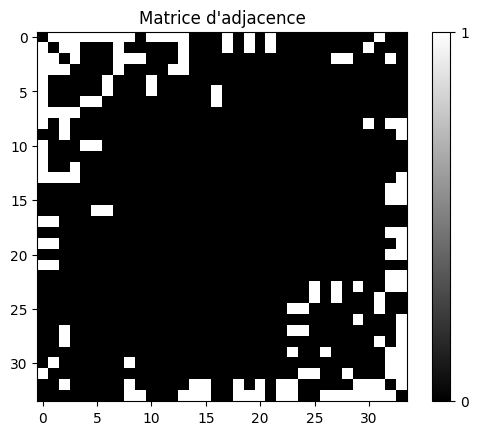

In [2]:
dataset = KarateClub()
data = dataset[0]

print(f'Nombre de noeuds: {dataset.num_features}')
print(f'Nombre de classes: {dataset.num_classes}')

# Matrice d'adjacence
A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
plt.imshow(A,cmap=plt.cm.gray)
plt.colorbar(ticks=[0, 1])
plt.title("Matrice d'adjacence")

Dans les données initiales, le champ `data.train_mask`contient un masque permettant de ne sélectionner dans les données qu'un membre de chaque classe

In [3]:
mask =  data.train_mask
print(mask)

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


On souhaite juste retrouver les groupes en fonction des données de l'entraîneur et du président. On modifie donc ce masque

In [4]:
mask[4]= False
mask[8]= False
mask[24]= False
mask[33]= True
print(mask)

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True])


On affiche le graphe avec les groupes, et le graphe qui servira pour l'entraînement : seules les données des noeuds jaunes seront connues.
On encode les informations des noeuds par un vecteur one hot encoder.

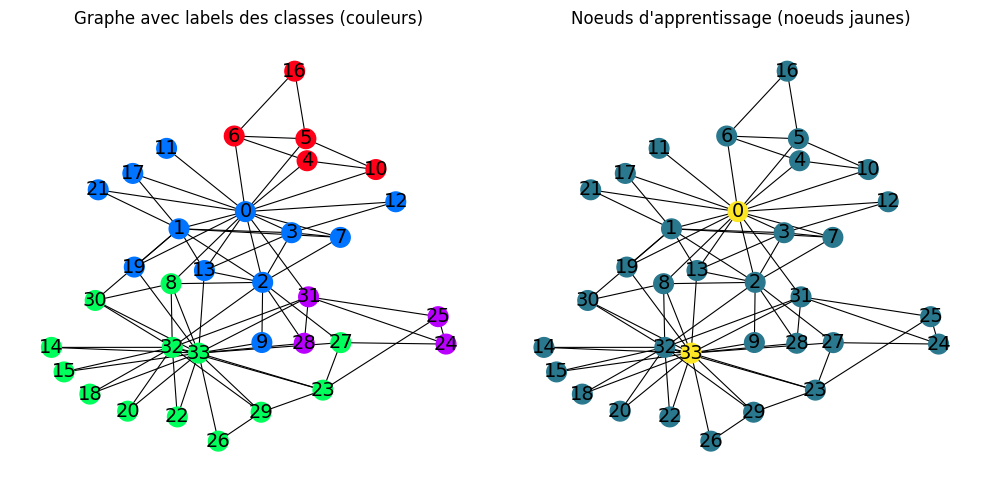

In [5]:
def oneHotEncoder(labels):
    return np.sum([(labels[:, i] == 1) * (i + 1) for i in range(4)], axis=0)


np.random.seed(2)
G = to_networkx(data, to_undirected=True)
fig,axs = plt.subplots(1,2,figsize=(10,5))
plt.subplot(121)
plt.axis('off')
nx.draw_networkx(G,pos=nx.kamada_kawai_layout(G),with_labels=True,node_size=200,node_color=data.y,cmap="hsv",
vmin=-2,vmax=3,width=0.8,edge_color="black",font_size=14)

plt.title("Graphe avec labels des classes (couleurs)")
plt.subplot(122)
plt.axis('off')
nx.draw_networkx(G,pos=nx.kamada_kawai_layout(G),with_labels=True,node_size=200,node_color=oneHotEncoder(data.y * mask[:,np.newaxis]),
vmin=-2,vmax=3,width=0.8,edge_color="black",font_size=14)
plt.title("Noeuds d'apprentissage (noeuds jaunes)")
plt.tight_layout()


On construit ensuite un GCN simple

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = nn.Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()

et on apprend ce modèle

In [7]:
# Fonction de perte en classification
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

def precision(pred_y, y):
    return (pred_y == y).sum() / len(y)

pertes = []
precisions = []
res = []

nb_epochs = 300

for epoch in range(nb_epochs):
    optimizer.zero_grad()

    _, z = model(data.x, data.edge_index)

    perte = criterion(z, data.y)

    p = precision(z.argmax(dim=1), data.y)

    perte.backward()
    optimizer.step()

    pertes.append(perte)
    precisions.append(p)
    res.append(z.argmax(dim=1))

On affiche ensuite l'évolution de l'entraînement

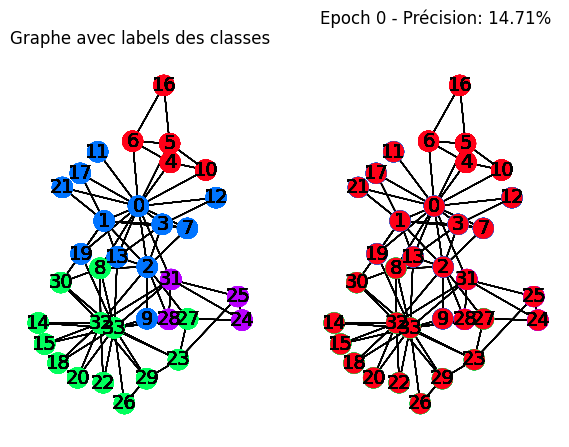

In [8]:
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    plt.subplot(121)
    plt.axis('off')
    nx.draw_networkx(G,
                pos=nx.kamada_kawai_layout(G),
                with_labels=True,
                node_size=200,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="black",
                font_size=14
                )

    plt.title("Graphe avec labels des classes")
    plt.subplot(122)
    plt.axis('off')
    nx.draw_networkx(G,pos=nx.kamada_kawai_layout(G, ),with_labels=True,node_size=200,
                    node_color=res[i],cmap="hsv",vmin=-2,vmax=3,width=0.8,edge_color="black",font_size=14
                    )
    plt.title(f'Epoch {i} - Précision: {precisions[i]*100:.2f}%', pad=20)


fig,axs = plt.subplots(1,2,figsize=(7,5))
anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [9]:
display(html)